In [4]:
import pandas as pd
import numpy as np
import dask.array as da
from dask_image.ndfilters import generic_filter as d_gf
import matplotlib.pyplot as plt

from helper import fast as fs
from helper import index as slowHelpers

In [15]:
import datetime
def load_raw(zone_number, chunk_size=(800,800)):
    labels = np.load(f"./raw_features/Labels3m_{zone_number}.npy")
    hpmf = np.load(f"./raw_features/HPMF_{zone_number}.npy")
    skyview = np.load(f"./raw_features/SkyViewFactor_{zone_number}.npy")
    impundment = np.load(f"./raw_features/Impoundment_{zone_number}.npy")
    slope = np.load(f"./raw_features/Slope_{zone_number}.npy")
    data_frame = pd.DataFrame({"label_3m":      labels.reshape(-1),
                               "hpmf_raw" :      hpmf.reshape(-1), 
                               "skyview_raw":    skyview.reshape(-1),
                               "impundment_raw": impundment.reshape(-1),
                               "slope_raw":      slope.reshape(-1)
                              })
    
    print("starting-skyview:", datetime.datetime.now())
    
    # Skyview
    # Manualy made
    data_frame["conic_mean"] = fs.conicMean(skyview, 5 , 0.975).reshape(-1)
    data_frame["skyview_non_ditch"] = fs.skyViewNonDitchAmplification(skyview).reshape(-1)
    data_frame["skyview_gabor"] = fs.skyViewGabor(skyview).reshape(-1)
    
    # Mass produced
    data_frame["skyview_mean_2"] = d_gf(da.from_array(skyview, chunks=chunk_size), np.nanmean, footprint=fs.create_circular_mask(2)).compute(scheduler='processes').reshape(-1)
    data_frame["skyview_mean_3"] = d_gf(da.from_array(skyview, chunks=chunk_size), np.nanmean, footprint=fs.create_circular_mask(3)).compute(scheduler='processes').reshape(-1)
    data_frame["skyview_mean_4"] = d_gf(da.from_array(skyview, chunks=chunk_size), np.nanmean, footprint=fs.create_circular_mask(4)).compute(scheduler='processes').reshape(-1)
    data_frame["skyview_mean_6"] = d_gf(da.from_array(skyview, chunks=chunk_size), np.nanmean, footprint=fs.create_circular_mask(6)).compute(scheduler='processes').reshape(-1)
    
    data_frame["skyview_median_2"] = d_gf(da.from_array(skyview, chunks=chunk_size), np.nanmedian, footprint=fs.create_circular_mask(2)).compute(scheduler='processes').reshape(-1)
    data_frame["skyview_median_4"] = d_gf(da.from_array(skyview, chunks=chunk_size), np.nanmedian, footprint=fs.create_circular_mask(4)).compute(scheduler='processes').reshape(-1)
    data_frame["skyview_median_6"] = d_gf(da.from_array(skyview, chunks=chunk_size), np.nanmedian, footprint=fs.create_circular_mask(6)).compute(scheduler='processes').reshape(-1)
    
    data_frame["skyview_std_6"] = d_gf(da.from_array(skyview, chunks=chunk_size), np.nanstd, footprint=fs.create_circular_mask(6)).compute(scheduler='processes').reshape(-1)
    data_frame["skyview_skew_2"] = d_gf(da.from_array(skyview, chunks=chunk_size), np.nanstd, footprint=fs.create_circular_mask(2)).compute(scheduler='processes').reshape(-1)
    
    print("starting-impoundment:", datetime.datetime.now())
    
    # Impoundment
    # Manualy made
    data_frame["impundment_amplified"]= fs.impoundmentAmplification(impundment).reshape(-1)
    data_frame["impoundment_stream_amplification"] = slowHelpers.streamAmplification(impundment).reshape(-1)
    
    # Mass produced
    data_frame["impundment_mean_2"] = d_gf(da.from_array(impundment, chunks=chunk_size), np.nanmean, footprint=fs.create_circular_mask(2)).compute(scheduler='processes').reshape(-1)
    data_frame["impundment_mean_3"] = d_gf(da.from_array(impundment, chunks=chunk_size), np.nanmean, footprint=fs.create_circular_mask(3)).compute(scheduler='processes').reshape(-1)
    data_frame["impundment_mean_4"] = d_gf(da.from_array(impundment, chunks=chunk_size), np.nanmean, footprint=fs.create_circular_mask(4)).compute(scheduler='processes').reshape(-1)
    data_frame["impundment_mean_6"] = d_gf(da.from_array(impundment, chunks=chunk_size), np.nanmean, footprint=fs.create_circular_mask(6)).compute(scheduler='processes').reshape(-1)
    
    data_frame["impundment_median_2"] = d_gf(da.from_array(impundment, chunks=chunk_size), np.nanmedian, footprint=fs.create_circular_mask(2)).compute(scheduler='processes').reshape(-1)
    data_frame["impundment_median_4"] = d_gf(da.from_array(impundment, chunks=chunk_size), np.nanmedian, footprint=fs.create_circular_mask(4)).compute(scheduler='processes').reshape(-1)
    data_frame["impundment_median_6"] = d_gf(da.from_array(impundment, chunks=chunk_size), np.nanmedian, footprint=fs.create_circular_mask(6)).compute(scheduler='processes').reshape(-1)
    
    data_frame["impundment_std_6"] = d_gf(da.from_array(impundment, chunks=chunk_size), np.nanstd, footprint=fs.create_circular_mask(6)).compute(scheduler='processes').reshape(-1)
    
    data_frame["impundment_skew_2"] = d_gf(da.from_array(impundment, chunks=chunk_size), np.nanstd, footprint=fs.create_circular_mask(2)).compute(scheduler='processes').reshape(-1)
    
    
    print("starting-hpmf:", datetime.datetime.now())
    # Hpmf
    # Manualy made
    data_frame["hpmf_filter"] = fs.hpmfFilter(hpmf).reshape(-1)
    data_frame["hpmf_gabor"] = fs.skyViewGabor(hpmf).reshape(-1)
    
    # Mass produced
    data_frame["hpmf_mean_2"] = d_gf(da.from_array(hpmf, chunks=chunk_size), np.nanmean, footprint=fs.create_circular_mask(2)).compute(scheduler='processes').reshape(-1)
    data_frame["hpmf_mean_3"] = d_gf(da.from_array(hpmf, chunks=chunk_size), np.nanmean, footprint=fs.create_circular_mask(3)).compute(scheduler='processes').reshape(-1)
    data_frame["hpmf_mean_4"] = d_gf(da.from_array(hpmf, chunks=chunk_size), np.nanmean, footprint=fs.create_circular_mask(4)).compute(scheduler='processes').reshape(-1)
    data_frame["hpmf_mean_6"] = d_gf(da.from_array(hpmf, chunks=chunk_size), np.nanmean, footprint=fs.create_circular_mask(6)).compute(scheduler='processes').reshape(-1)
    
    data_frame["hpmf_median_2"] = d_gf(da.from_array(hpmf, chunks=chunk_size), np.nanmedian, footprint=fs.create_circular_mask(2)).compute(scheduler='processes').reshape(-1)
    data_frame["hpmf_median_4"] = d_gf(da.from_array(hpmf, chunks=chunk_size), np.nanmedian, footprint=fs.create_circular_mask(4)).compute(scheduler='processes').reshape(-1)
    data_frame["hpmf_median_6"] = d_gf(da.from_array(hpmf, chunks=chunk_size), np.nanmedian, footprint=fs.create_circular_mask(6)).compute(scheduler='processes').reshape(-1)
    
    data_frame["hpmf_std_6"] = d_gf(da.from_array(hpmf, chunks=chunk_size), np.nanstd, footprint=fs.create_circular_mask(6)).compute(scheduler='processes').reshape(-1)
    
    data_frame["hpmf_skew_2"] = d_gf(da.from_array(hpmf, chunks=chunk_size), np.nanstd, footprint=fs.create_circular_mask(2)).compute(scheduler='processes').reshape(-1)
    
    print("starting-slope:", datetime.datetime.now())
    # Slope
    # Manualy made
    data_frame["slope_non_ditch"] = fs.slopeNonDitchAmplification(slope).reshape(-1)
    
    # Mass produced
    data_frame["slope_mean_2"] = d_gf(da.from_array(slope, chunks=chunk_size), np.nanmean, footprint=fs.create_circular_mask(2)).compute(scheduler='processes').reshape(-1)
    data_frame["slope_mean_3"] = d_gf(da.from_array(slope, chunks=chunk_size), np.nanmean, footprint=fs.create_circular_mask(3)).compute(scheduler='processes').reshape(-1)
    data_frame["slope_mean_4"] = d_gf(da.from_array(slope, chunks=chunk_size), np.nanmean, footprint=fs.create_circular_mask(4)).compute(scheduler='processes').reshape(-1)
    data_frame["slope_mean_6"] = d_gf(da.from_array(slope, chunks=chunk_size), np.nanmean, footprint=fs.create_circular_mask(6)).compute(scheduler='processes').reshape(-1)
    
    data_frame["slope_median_2"] = d_gf(da.from_array(slope, chunks=chunk_size), np.nanmedian, footprint=fs.create_circular_mask(2)).compute(scheduler='processes').reshape(-1)
    data_frame["slope_median_4"] = d_gf(da.from_array(slope, chunks=chunk_size), np.nanmedian, footprint=fs.create_circular_mask(4)).compute(scheduler='processes').reshape(-1)
    data_frame["slope_median_6"] = d_gf(da.from_array(slope, chunks=chunk_size), np.nanmedian, footprint=fs.create_circular_mask(6)).compute(scheduler='processes').reshape(-1)
    
    data_frame["slope_std_6"] = d_gf(da.from_array(slope, chunks=chunk_size), np.nanstd, footprint=fs.create_circular_mask(6)).compute(scheduler='processes').reshape(-1)
    
    data_frame["slope_skew_2"] = d_gf(da.from_array(slope, chunks=chunk_size), np.nanstd, footprint=fs.create_circular_mask(2)).compute(scheduler='processes').reshape(-1)
    
    return data_frame

In [14]:
# %%time
# zone_with_features = load_raw(1)
# zone_with_features.to_pickle("zone_1.pickle")
# zone_with_features = None

starting-skyview: 2019-04-11 23:54:36.226787
2077027
starting-impoundment: 2019-04-12 00:50:49.641597
starting-hpmf: 2019-04-12 01:08:25.651326
starting-slope: 2019-04-12 02:03:55.116604
Wall time: 2h 28min 24s


In [15]:
# %%time
# zone_with_features = load_raw(2)
# zone_with_features.to_pickle("zone_2.pickle")
# zone_with_features = None

starting-skyview: 2019-04-12 02:23:00.931068
2201367
starting-impoundment: 2019-04-12 03:18:58.367510
starting-hpmf: 2019-04-12 03:36:30.758919
starting-slope: 2019-04-12 04:31:58.864833
Wall time: 2h 28min 6s


In [16]:
# %%time
# zone_with_features = load_raw(3)
# zone_with_features.to_pickle("zone_3.pickle")
# zone_with_features = None

starting-skyview: 2019-04-12 04:51:07.139715
2797715
starting-impoundment: 2019-04-12 05:47:06.394293
starting-hpmf: 2019-04-12 06:04:39.399061
starting-slope: 2019-04-12 07:00:08.355700
Wall time: 2h 28min 47s


In [12]:
%%time
zone_with_features =load_raw(4)

zone_with_features.to_pickle("zone_4.pickle")
#zone_with_features = None

<class 'list'>
30
Wall time: 3min 16s


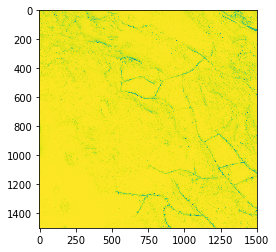

In [14]:
plt.imshow(zone_with_features["skyview_raw"].values.reshape((1500,1500)))

In [ ]:
%%time
zone_with_features =load_raw(5)
zone_with_features.to_pickle("zone_5.pickle")
zone_with_features = None

In [ ]:
%%time
zone_with_features =load_raw(6)
zone_with_features.to_pickle("zone_6.pickle")
zone_with_features = None

In [ ]:
%%time
zone_with_features =load_raw(7)
zone_with_features.to_pickle("zone_7.pickle")
zone_with_features = None

In [ ]:
%%time
zone_with_features =load_raw(8)
zone_with_features.to_pickle("zone_8.pickle")
zone_with_features = None

In [ ]:
%%time
zone_with_features =load_raw(9)
zone_with_features.to_pickle("zone_9.pickle")
zone_with_features = None

In [44]:
zone_3.drop(["label_raw"], axis=1)

,label_raw,hpmf_raw,skyview_raw,impundment_raw,slope_raw,conic_mean,skyview_non_ditch,skyview_mean_2,skyview_mean_3,skyview_mean_4,...,slope_non_ditch,slope_mean_2,slope_mean_3,slope_mean_4,slope_mean_6,slope_median_2,slope_median_4,slope_median_6,slope_std_6,slope_skew_2
0,0,-1130113270,0.991990,984612864,5,0.991990,1.0,0.993655,0.994245,0.994486,...,0,3,3,2,3,4,3,3,1,1
1,0,-1138501878,0.993762,1028243456,2,0.993762,1.0,0.994124,0.994262,0.993851,...,0,3,3,3,3,3,3,3,1,1
2,0,-1138501878,0.996549,1018445824,1,0.996549,1.0,0.995359,0.993899,0.993388,...,0,1,2,3,3,1,3,3,2,1
3,0,0,0.997279,1011154944,1,0.997279,1.0,0.995311,0.993862,0.992810,...,0,1,2,3,4,1,3,4,2,0
4,0,0,0.996672,1009876992,1,0.996672,1.0,0.994203,0.993247,0.990370,...,0,2,2,3,4,2,3,4,3,1
5,0,-1138501878,0.993235,0,4,0.993235,1.0,0.993486,0.989415,0.987011,...,0,3,4,4,4,3,4,4,3,2
6,0,-1130113270,0.994499,1016332288,3,0.994499,1.0,0.985664,0.982955,0.984831,...,0,5,6,5,4,4,4,4,3,3
7,0,-1113336054,0.975987,1020084224,10,0.975987,1.0,0.975306,0.980128,0.983125,...,0,8,7,6,4,10,5,4,3,3
8,0,-1102263091,0.950124,1048224768,11,0.950124,1.0,0.970972,0.978185,0.983491,...,0,9,7,6,4,11,6,4,3,3
9,0,-1104947446,0.979405,1047005184,13,0.979405,1.0,0.969861,0.976403,0.983010,...,0,8,7,6,4,10,7,4,3,4
